**Gaussian Mixture Model (GMM)** is a probabilistic model that assumes all the data points are generated from a mixture of finite number of Gaussian distributions with unknown parameters.  

An **Expectation Maximization** algorithm is an iterative method to find maximum likelihood or maximum of a posterior (MAP) estimates of parameters in satistical models, when the model depends on unobserved latent variables (variables that are inferred).

A Gaussian Distribution - If a random variable X is a Gaussian, then it has the following PDF:

$$
p_{X}(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-(x-\mu)^{2}}{2\sigma^{2}}}
$$

The two parameters are $\mu$, the mean, and the $\sigma^{2}$, the variance

Derivation of The EM equation - 

The EM algorithm is actually minimizing a lower bound on the log likelihood. Say we have observed a random variable Y. There is some hidden variable C that Y depends on. The distributions of C and Y have some parameters $\theta$ that is not known, but are interested in finding. We need a key fact: Jensen's inequality before we derive the algorithm. The specific case of Jensen's inequality that we need states that

$$
\log{(E[X])} >= E[\log{(X)}]
$$


We want to maximize the log-likelihood:
$\log_{py}{(y|\theta)}$ 

(Marginalizing over C and introducing $q_{C}(c)$/$q_{C}(c)$) = $\log$$\Bigl(\sum_{c}q_{C}(c)\frac{p_{Y,C}(y,c|\theta)}{q_{C}(c)}\Bigr)$

(Using Jensen's inequality) >= $E_{qC}$$\Bigl[\log \frac{p_{Y,C}(y,C|\theta)}{q_{c}(C)} \Bigr]$

Rearrange the last version:
$E_{qC}$ $\Bigl[\log \frac{p_{Y,C}(y,C|\theta)}{q_{c}(C)} \Bigr]$ = $E_{qC}$[$\log_{p_{Y,C}}$ $(y, C|\theta)$] - $E_{q_{c}}$[$\log_{q_{C}(C)}$]

Maximizing with respect to $\theta$ will give us:
$\theta$ <- $argmax_{\theta}$ $E_{q_{c}}$[$\log_{p_{Y,C}}(y, C|\theta)$]

That's the M-step. Now we'll rearrange a different way:
$E_{qC}$ $\Bigl[\log \frac{p_{Y,C}(y,C|\theta)}{q_{c}(C)} \Bigr]$ = $E_{qC}$ $\Bigl[\log \frac{p_{Y}(y;\theta) p_{C|Y}(C|y;\theta)}{q_{C}(C)} \Bigr]$

 = $\log_{p_{Y}}(y;\theta)$ - $E_{q_{c}}$ $\Bigl[ \log \frac{q_{C}(C)}{p_{C|Y}(C|y;\theta)} \Bigr]$
 
 = $\log_{p_{Y}}(y;\theta)$ - $D(q_{C}(.)||p_{C|Y}(.|y;\theta))$
 
Maximization with respect to $q_{c}$ will give us:
$$
q_{c}(.) <- p_{C|Y}(.|y;\theta)
$$
That's the E step.

In short the two steps can be summarized as:

1) E-Step: Compute $p_{n,k}$ = $p(c_{k}|x^{(n)}, \theta_{1:K}).$ Let $p_{k}$ = $\sum_{n}p_{n,k}$ <br><br>
2) M-Step: Compute new mean, covariance, and class prior for each class.<br><br>
$\mu_{k}$ <- $\sum_{n}p_{n,k}x^{(n)}/p_{k}$
<br><br>
$\sigma_{k}$ <- $\sum_{n}p_{n, k}(x^{(n)} - \mu_{k}(x^{(n)} - \mu_{k})^T / p_{k})$

In [232]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2, norm

In [233]:
#Loading the data
with open('data/faithful.txt', 'rt') as f:
    dataReader = csv.reader(f, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

In [234]:
#Number of Gaussian Mixture Model
ngmm = 2

Initializing the Mean and Covariance

In [235]:
#Mean
mu = np.array([[2, 70], [4, 80]], dtype='float')

In [236]:
#Covariance
sigma = np.array([[[1, 0], [0, 3]], [[0.5, 0.2], [0.2, 0.6]]], dtype='float')

In [237]:
#This function checks if the covariance matrix is legal
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print(covmatIsLegal(sigma))

True


In [238]:
gmm = [{'mean':mu[m], 'covariance':sigma[m], "prior":0.5} for m in range(ngmm)]

In [239]:
#These functions plot the Gaussian Mixture Model

def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))
    #plt.show()

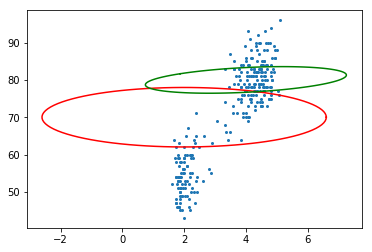

In [240]:
gmmplot(data, gmm)
plt.show()

Optimizing the Mixture Model Using EM Algorithm

In [241]:
#probability that a point came from a Gaussian with given parameters
def probability(points, parameters_dict):
    prior = parameters_dict['prior']
    mu = parameters_dict['mean']
    sigma = parameters_dict['covariance']
    #print(sigma)
    prob = prior
    for i in range(0, len(points)):
        prob *= norm.pdf(points[i], mu[i], sigma[i][i])
    return prob

In [242]:
def expectation_non_scale(data, parameters):
    posterior = []
    for i in range(0, data.shape[0]):
        x = data[i][0]
        y = data[i][1]
        cluster1 = probability([x, y], parameters[0])
        cluster2 = probability([x, y], parameters[1])
        #print(cluster1)
        #print(cluster2)
        if cluster1 > cluster2:
            posterior.append(1)
        else:
            posterior.append(2)
    return posterior

In [243]:
def expectation(data, parameters):
    posterior = []
    for i in range(0, data.shape[0]):
        x = data[i][0]
        y = data[i][1]
        clusters_prob_value = []
        for j in range(0, len(parameters)):
            clusters_prob_value.append(probability([x, y], parameters[j]))
        #print(clusters_prob_value)
        clusters_prob_values = np.array(clusters_prob_value)
        #print(clusters_prob_values.argmax())
        posterior.append(clusters_prob_values.argmax())
    return posterior

In [244]:
#For this Excerise I am not changing the covariance matrix. 
def maximization_mean_non_scale(posterior, data, parameters):
    data = pd.DataFrame(data=data)
    data['c'] = posterior
    print(data.shape)
    cluster_1_points = data[data['c'] == 1]
    cluster_2_points = data[data['c'] == 2]
    cluster_1_count = len(cluster_1_points)
    cluster_2_count = len(cluster_2_points)
    total = cluster_1_count + cluster_2_count
    prior_1 = parameters[0]['prior']
    prior_2 = parameters[1]['prior']
    mu1 = [cluster_1_points[0].mean(), cluster_1_points[1].mean()]
    mu2 = [cluster_2_points[0].mean(), cluster_2_points[1].mean()]
    sigma1 = parameters[0]['covariance']
    sigma2 = parameters[1]['covariance']
    sigma1 = np.array(sigma1)
    sigma2 = np.array(sigma2)
    dict_1 = {'mean': mu1, 'covariance': sigma1, 'prior': prior_1}
    dict_2 = {'mean': mu2, 'covariance': sigma2, 'prior': prior_2}
    parameters = [dict_1, dict_2]
    return parameters

In [251]:
def maximization_mean(posterior, data, parameters):
    data = pd.DataFrame(data=data)
    data['c'] = posterior
    new_parameters = []
    for i in range(0, len(parameters)):
        points = data[data['c'] == i]
        count_points = len(points)
        prior = parameters[i]['prior']
        mu = []
        for j in range(0, data.shape[1]-1):
            mu.append(points[j].mean())
        #print(mu)
        sigma = parameters[i]['covariance']
        sigma = np.array(sigma)
        vals_dict = {'mean':mu, 'covariance': sigma, 'prior':prior}
        new_parameters.append(vals_dict)
    return new_parameters

In [252]:
gmmcp = gmm.copy()
posterior = expectation(data, gmmcp)
print(posterior)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [253]:
gmmcp = gmm.copy()
posterior = expectation(data, gmmcp)
print(posterior)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [254]:
parameters = maximization_mean(posterior, data, gmmcp)
print(parameters)

[{'mean': [3.198149253731343, 67.50248756218906], 'covariance': array([[ 1.,  0.],
       [ 0.,  3.]]), 'prior': 0.5}, {'mean': [4.307732394366198, 80.507042253521121], 'covariance': array([[ 0.5,  0.2],
       [ 0.2,  0.6]]), 'prior': 0.5}]


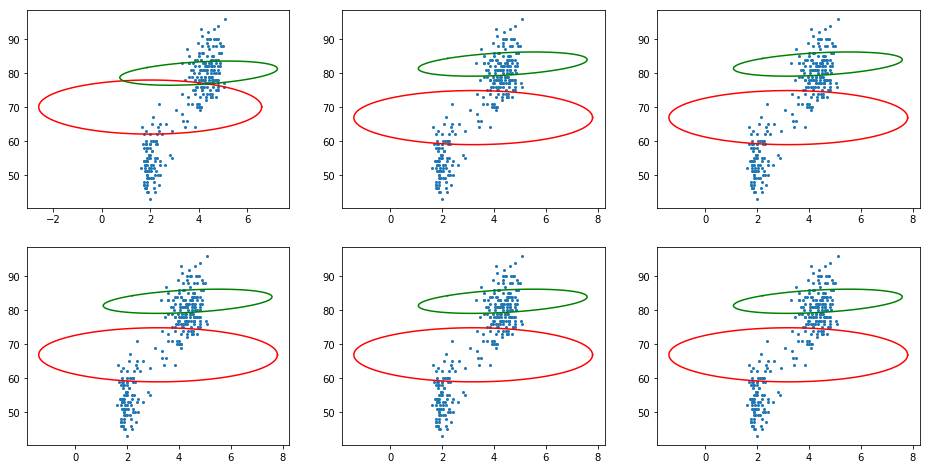

In [255]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)
#print(data)
#print(gmmcp)
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
        #print(gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)
plt.show()

As an extension to this I have created my own data and applied the EM algorithm. 

In [144]:
print(np.array(data).shape)

(272, 2)


In [154]:
x1, y1 = np.random.multivariate_normal([1, 2],[[0.5, 0],[0, 1]], 100).T
x2, y2 = np.random.multivariate_normal([2, 3],[[1, 0],[0, 2]], 100).T
new_data = []
for i in range(0, 100):
    each_point = [x1[i], y1[i]]
    new_data.append(each_point)
for i in range(0, 100):
    each_point = [x2[i], y1[i]]
    new_data.append(each_point)    
print(np.array(new_data).shape) 
new_data = np.array(new_data)

(200, 2)


In [155]:
#Mean
mu = np.array([[1, 2], [2, 3]], dtype='float')

In [161]:
#Covariance
sigma = np.array([[[0.5, 0], [0, 1]], [[1, 0], [0, 2]]], dtype='float')

In [162]:
print(covmatIsLegal(sigma))

True


In [163]:
gmm = [{'mean':mu[m], 'covariance':sigma[m], "prior":0.5} for m in range(ngmm)]

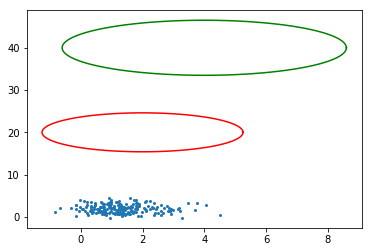

In [167]:
gmmplot(new_data, gmm)
plt.show()

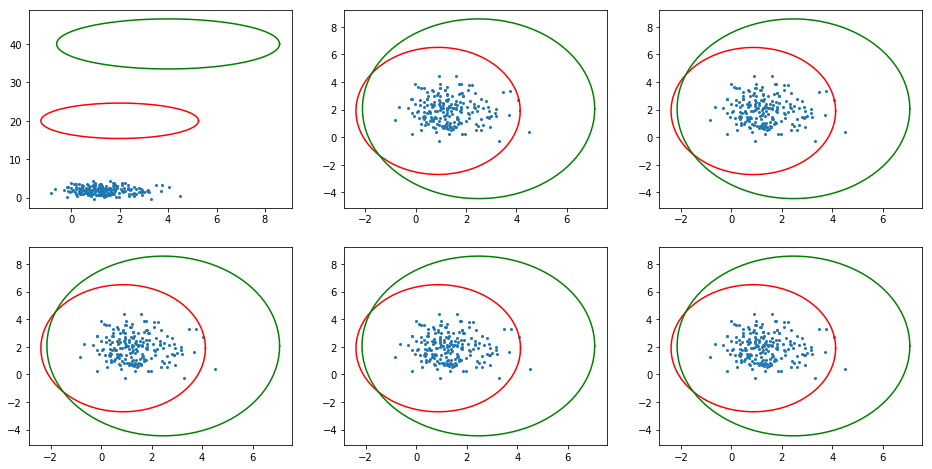

In [166]:
# make a true copy of our model
gmmcp = gmm.copy()
#print(data)
#print(gmmcp)
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(new_data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(new_data, gmmcp)
        gmmcp = maximization_mean(posterior, new_data, gmmcp)
        #print(gmmcp)
# plot final status
plt.subplot(236)
gmmplot(new_data,gmmcp)
plt.show()